In [100]:
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [87]:
import matplotlib.gridspec as gridspec
import yash_bls 


In [93]:
def doSearch(time, flux, minPeriod, maxPeriod, ):

    SNR, period, epoch, duration, depth, transitModel, period_guesses, \
            convolved_bls = yash_bls.do_bls_and_fit(time, flux, minPeriod, maxPeriod)

    phase, phasedFlux = yash_bls.getPhase(time, flux, period, epoch)
    phaseModel, phasedFluxModel = yash_bls.getPhase(time, transitModel, period, epoch)

    secTime, secSNR, secPer, secEpoch, secDur, secModel = yash_bls.findSecondary(time, flux, period, epoch, duration)
    if secSNR > 5 and abs(period - secPer) < 0.05:
        secPhase, secPhaseModel = yash_bls.getPhase(secTime, secModel, secPer, epoch)
        idx = len(secPhase[secPhase < 0])
    else:
        secPhase, secPhaseModel, idx = [], [], 1


    # Odd/Even plot 
    fitT_odd, fitT_even = yash_bls.computeOddEvenModels(time, flux, period, epoch)
    phaseModel_odd, phasedFluxModel_odd = yash_bls.getPhase(time, fitT_odd.transitmodel, period * 2, epoch)
    phaseModel_even, phasedFluxModel_even = yash_bls.getPhase(time, fitT_even.transitmodel, period * 2, epoch + period)
    depthOdd = fitT_odd.fitresultplanets['pnum0']['rprs'] ** 2
    depthEven = fitT_even.fitresultplanets['pnum0']['rprs'] ** 2
    phaseOdd, fluxOdd = yash_bls.getPhase(time, flux, period * 2, epoch)
    phaseEven, fluxEven = yash_bls.getPhase(time, flux, period * 2, epoch + period)
    x1, x2 = -duration, duration
    y1, y2 = -3*np.std(fluxOdd), 3*np.std(fluxOdd)
    if min(fluxOdd) < y1:
        y1 = min(fluxOdd) - np.std(fluxOdd)
    # sigma = abs(depth1 - depth2) / sqrt(u1^2 + u2^2)
    durOdd = yash_bls.computeTransitDuration(period, fitT_odd.fitresultstellar['rho'], fitT_odd.fitresultplanets['pnum0']['rprs'])
    durEven = yash_bls.computeTransitDuration(period, fitT_odd.fitresultstellar['rho'], fitT_even.fitresultplanets['pnum0']['rprs'])
    sigma = yash_bls.computePointSigma(time, flux, transitModel, period, epoch, duration)
    nOddPoints = np.sum((-durOdd*0.5 < phaseOdd) & (phaseOdd < durOdd * 0.5))
    nEvenPoints = np.sum((-durEven*0.5 < phaseEven) & (phaseEven < durEven * 0.5))
    uOdd, uEven = sigma / np.sqrt(nOddPoints), sigma / np.sqrt(nEvenPoints)
    depthDiffSigma = abs(depthOdd - depthEven) / np.sqrt(uOdd**2 + uEven**2)

    return locals()


def plotSearch(outs, secondary=False):
    x1 = outs['x1']
    x2 = outs['x2']
    gs = gridspec.GridSpec(3,2)
    ax1 = plt.subplot(gs[0,:])
    axOdd = plt.subplot(gs[1,0])
    axEven = plt.subplot(gs[1,1])
    ax3 = plt.subplot(gs[2,:])
    gs.update(wspace = 0, hspace = 0.5)
    ax1.plot(outs['time'], outs['flux'], 'k')
    y1, y2 = ax1.get_ylim()
    ax1.vlines(np.arange(outs['epoch'], outs['time'][-1], outs['period']), y1, y2, 
               color = 'r', linestyles = 'dashed', linewidth = 0.5)
    ax1.axis([outs['time'][0], outs['time'][-1], y1, y2])
    ax1.set_title('kplr%s;    best period = %8.6g days;    SNR = %8.6g' %('K2', outs['period'], outs['SNR']))
    ax1.set_xlabel('days')
    axOdd.set_ylabel('flux')
    axOdd.scatter(outs['phaseOdd'], outs['fluxOdd'], marker = '.', s = 1, color = 'k', alpha = 1)
    axOdd.plot(outs['phaseModel_odd'], outs['phasedFluxModel_odd'], 'r')
    axOdd.axhline(-outs['depthOdd'], x1, x2)
    axOdd.axis([x1,x2,y1,y2])
    axOdd.set_title('odd')
    axEven.scatter(outs['phaseEven'], outs['fluxEven'], marker = '.', s = 1, color = 'k', alpha = 1)
    axEven.plot(outs['phaseModel_even'], outs['phasedFluxModel_even'], 'r')
    axEven.axhline(-outs['depthEven'], x1, x2)
    axEven.yaxis.tick_right()
    axEven.axis([x1,x2,y1,y2])
    axEven.set_title('even')
    if secondary:
        plt.plot(outs['secPhase'][:idx], outs['secPhaseModel'][:idx], 'c')
        plt.plot(outs['secPhase'][idx:], outs['secPhaseModel'][idx:], 'c')
    ax3.scatter(outs['phase'], outs['phasedFlux'], marker = '.', s = 1, color = 'k')
    ax3.plot(outs['phaseModel'], outs['phasedFluxModel'], 'r')
    y1, y2 = -3*np.std(outs['phasedFlux']), 3*np.std(outs['phasedFlux'])
    if min(outs['phasedFlux']) < y1:
        y1 = min(outs['phasedFlux']) - np.std(outs['phasedFlux'])
    ax3.axis([outs['phase'][0], outs['phase'][-1], y1, y2])
    ax3.set_xlabel('phase [hours]')
    ax3.text(0.5, 1.25, 'depth diff sigma = %.3f' %outs['depthDiffSigma'], horizontalalignment = 'center',
        verticalalignment = 'center', transform = ax3.transAxes)

def get_qf(time,flux,epoch,period,transitmodel=None):
    date1 = (time - epoch) + 0.5*period
    phi1 = (((date1 / period) - np.floor(date1/period)) * period) - 0.5*period
    q1 = np.sort(phi1)
    f1 = (flux[np.argsort(phi1)]) * -1.E6
    if transitmodel is not None:
        m1 = (transitmodel[np.argsort(phi1)]) * -1.E6
        return q1,f1,m1
    else:
        return q1,f1


In [94]:
filename = 'wasp47.csv'

time, flux = np.genfromtxt(filename, unpack = True, delimiter=',')

mask = np.isfinite(flux) * np.isfinite(time)
time1 = flux[mask] # !!!! I mixed up flux and time in my wasp47.csv file
flux1 = time[mask] # !!!!

time = time1
flux = flux1

flux = (flux / np.median(flux) ) -1.0

time, flux = yash_bls.outlierRemoval(time, flux)
flux = yash_bls.medianDetrend(flux, 26)

# Main transit search
minPeriod = 0.5     # Limitations of BLS Fortran code
maxPeriod = (time[-1] - time[0]) / 3.

outs = doSearch(time, flux, minPeriod, maxPeriod, )

(2.0780443085618234, -2.0792386147869655)

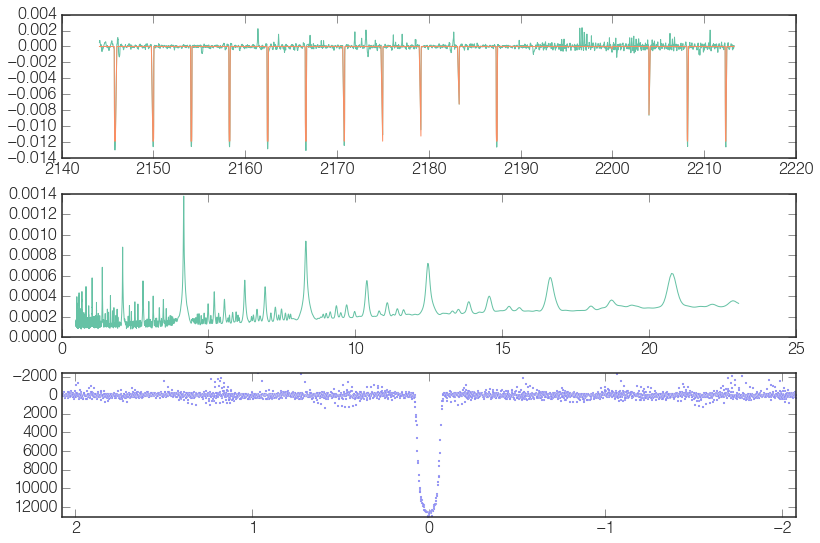

In [68]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[12,9])
ax1.plot(time, flux ) 
ax1.plot(time, outs['transitModel'] ) 

#ax2.plot(time, flux ) 
ax2.plot(outs['period_guesses'], outs['convolved_bls'])
q,f = get_qf(time,flux, outs['epoch'], outs['period'])
ax3.scatter(q,f, s=4)
ax3.set_ylim([np.max(f),np.min(f)])
ax3.set_xlim([np.max(q),np.min(q)])

In [69]:


fluxmin = flux - outs['transitModel']

#time, flux = yash_bls.outlierRemoval(time, fluxmin)
#fluxmin = yash_bls.medianDetrend(fluxmin, 26)

# Main transit search
minPeriod = 0.5     # Limitations of BLS Fortran code
maxPeriod = (time[-1] - time[0]) / 3.

outsmin = doSearch(time, fluxmin, minPeriod, maxPeriod, )

(4.5061860247833465, -4.5107891008328664)

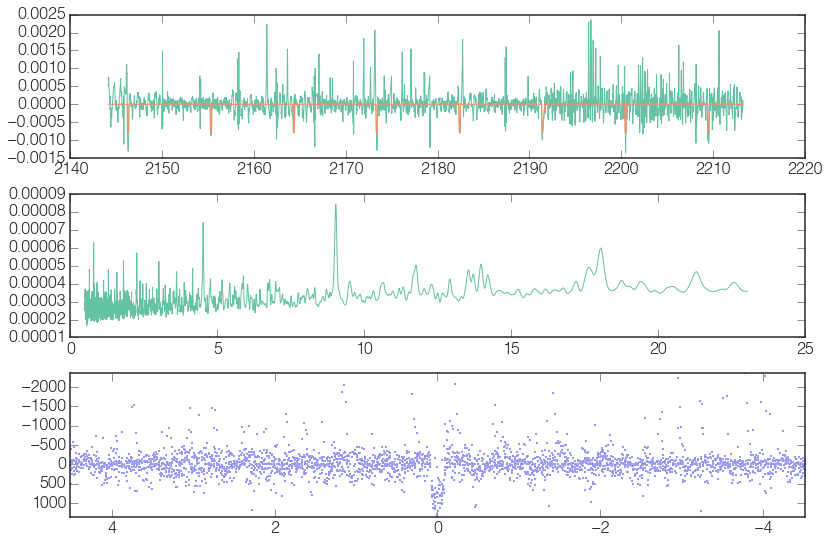

In [71]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[12,9])
ax1.plot(time, fluxmin ) 
ax1.plot(time, outsmin['transitModel'] ) 

#ax2.plot(time, flux ) 
ax2.plot(outsmin['period_guesses'], outsmin['convolved_bls'])
q,f = get_qf(time,fluxmin, outsmin['epoch'], outsmin['period'])
ax3.scatter(q,f, s=4)
ax3.set_ylim([np.max(f),np.min(f)])
ax3.set_xlim([np.max(q),np.min(q)])

In [72]:


fluxmin2 = fluxmin - outsmin['transitModel']

#time, flux = yash_bls.outlierRemoval(time, fluxmin)
#fluxmin = yash_bls.medianDetrend(fluxmin, 26)

# Main transit search
minPeriod = 0.5     # Limitations of BLS Fortran code
maxPeriod = (time[-1] - time[0]) / 3.

outsmin2 = doSearch(time, fluxmin2, minPeriod, maxPeriod, )

(0.39429774279539109, -0.39425003751298454)

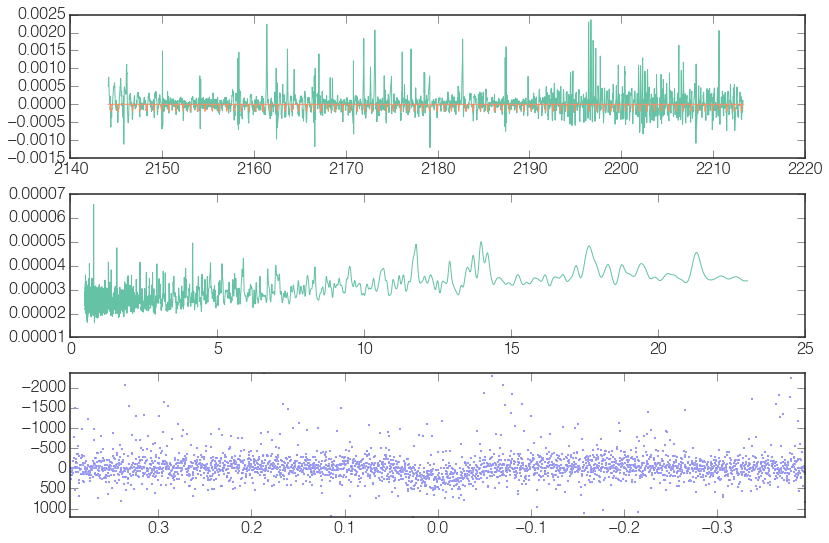

In [73]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[12,9])
ax1.plot(time, fluxmin2 ) 
ax1.plot(time, outsmin2['transitModel'] ) 

#ax2.plot(time, flux ) 
ax2.plot(outsmin2['period_guesses'], outsmin2['convolved_bls'])
q,f = get_qf(time,fluxmin2, outsmin2['epoch'], outsmin2['period'])
ax3.scatter(q,f, s=4)
ax3.set_ylim([np.max(f),np.min(f)])
ax3.set_xlim([np.max(q),np.min(q)])

In [78]:
print(outs['period'], outs['SNR'])
print(outsmin['period'], outsmin['SNR'])
print(outsmin2['period'],  outsmin2['SNR'])

4.15917086308 421.969528469
9.03173454602 24.9959858275
0.789546823078 13.9971685627


In [77]:
4.1591708630839328 / 0.78954682307784974

5.267795071190903

In [81]:


fluxmin3 = fluxmin2 - outsmin2['transitModel']

#time, flux = yash_bls.outlierRemoval(time, fluxmin)
#fluxmin = yash_bls.medianDetrend(fluxmin, 26)

# Main transit search
minPeriod = 0.5     # Limitations of BLS Fortran code
maxPeriod = (time[-1] - time[0]) / 3.

outsmin3 = doSearch(time, fluxmin3, minPeriod, maxPeriod, )

(2.0794264550074004, -2.0790665754856197)

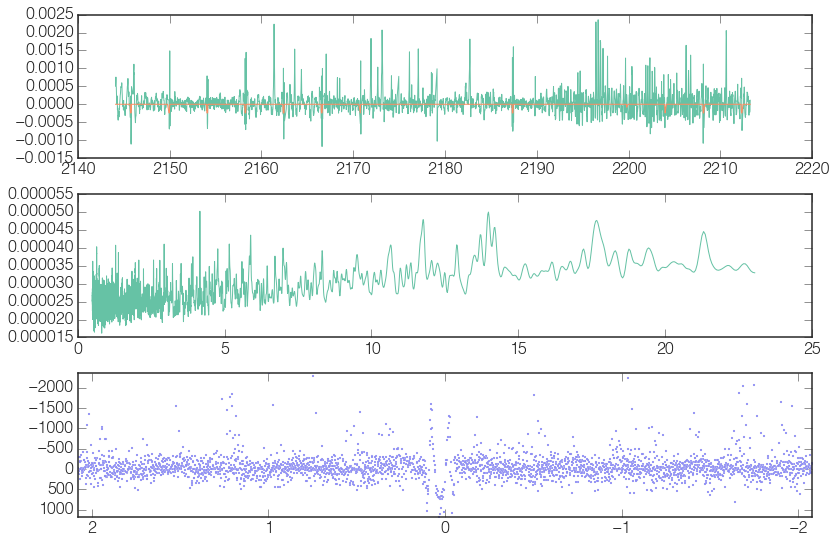

In [82]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[12,9])
ax1.plot(time, fluxmin3 ) 
ax1.plot(time, outsmin3['transitModel'] ) 

#ax2.plot(time, flux ) 
ax2.plot(outsmin3['period_guesses'], outsmin3['convolved_bls'])
q,f = get_qf(time,fluxmin3, outsmin3['epoch'], outsmin3['period'])
ax3.scatter(q,f, s=4)
ax3.set_ylim([np.max(f),np.min(f)])
ax3.set_xlim([np.max(q),np.min(q)])

In [83]:
outs

{'SNR': 421.96952846876121,
 'convolved_bls': array([ 0.00033225,  0.00034177,  0.00035353, ...,  0.0001447 ,
         0.00013177,  0.00012505]),
 'depth': 0.011876680987410373,
 'depthDiffSigma': 1.897610899181448,
 'depthEven': 0.011803816049107591,
 'depthOdd': 0.011929546758668518,
 'durEven': 4.2945209379902822,
 'durOdd': 4.2967885843287554,
 'duration': 5.4358004743484596,
 'epoch': 2145.8181124895377,
 'fitT_even': <ktransit.fittransit.FitTransit at 0x1171c27d0>,
 'fitT_odd': <ktransit.fittransit.FitTransit at 0x116fcc850>,
 'flux': array([ 0.00050952,  0.00061208,  0.0007578 , ..., -0.00015678,
         0.        ,  0.00011196]),
 'fluxEven': array([-0.0126077 , -0.01298794, -0.01256593, ..., -0.01262777,
        -0.01284558, -0.01255444]),
 'fluxOdd': array([-0.0130542 , -0.01258255, -0.01256599, ..., -0.01245131,
        -0.01256097, -0.01253383]),
 'idx': 1,
 'maxPeriod': 23.04694614343801,
 'minPeriod': 0.5,
 'nEvenPoints': 36,
 'nOddPoints': 48,
 'period': 4.1591708630839

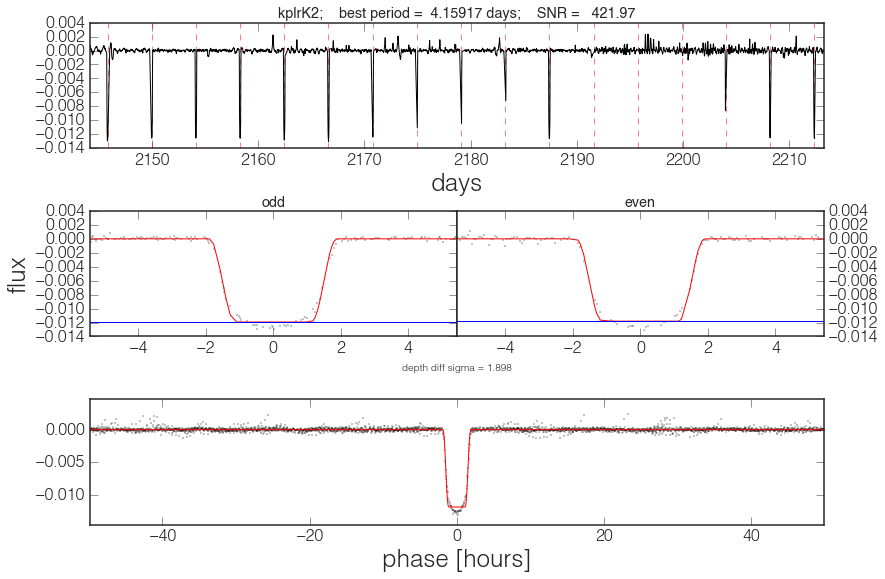

In [99]:
plotSearch(outs)
fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(9)